Careful, these constants may be different for you:

In [1]:
DATA_PATH = '~/Desktop/sdss_dr7_photometry_source.csv.gz'

In [2]:
import matplotlib.pyplot as plt
import mclearn.viz
import numpy as np
import pandas as pd
import sklearn.neighbors

%matplotlib inline

First import the training and testing sets

In [3]:
def load_data(x_cols=['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z'],
              meta_cols=['ra', 'dec'],
              class_col='class',
              class_val='Galaxy',
              train_samples_num=1000000,
              test_samples_num=500000):

    data_iter = pd.read_csv(
        DATA_PATH,
        iterator=True,
        chunksize=100000,
        usecols=x_cols + meta_cols + [class_col])


    # Filter out anything that is not a galaxy without loading the whole file into memory.
    data = pd.concat(chunk[chunk[class_col] == class_val]
                     for chunk in data_iter)

    train_meta = data[:train_samples_num][meta_cols]
    train_X = data[:train_samples_num][x_cols].as_matrix()
    
    test_meta = data[-test_samples_num:][meta_cols]
    test_X = data[-test_samples_num:][x_cols].as_matrix()
    
    return (train_meta, train_X), (test_meta, test_X)

(train_meta, train_X), (test_meta, test_X) = load_data()

Fit the training data.

In [4]:
kde = sklearn.neighbors.KernelDensity(
        bandwidth=.2,  # By experimentation.
        kernel='epanechnikov',  # Resembles Gaussian within short distance, but is faster.
        leaf_size=400,  # For speed.
        rtol=1e-5  # Slightly increased accuracy, but better speed.
    ).fit(train_X)

Find densities on the test set. __This can take a while.__

In [5]:
test_densities = kde.score_samples(test_X)
test_densities = np.exp(test_densities)

Plot.

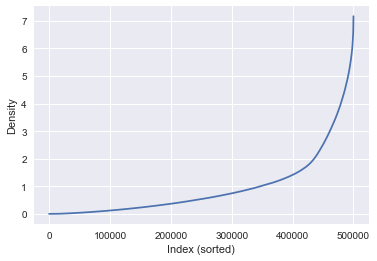

In [6]:
def plot():
    x = range(len(test_densities))
    y = sorted(test_densities)
    plt.plot(x, y)
    plt.ylabel('Density')
    plt.xlabel('Index (sorted)')

plot()

This time a histogram.

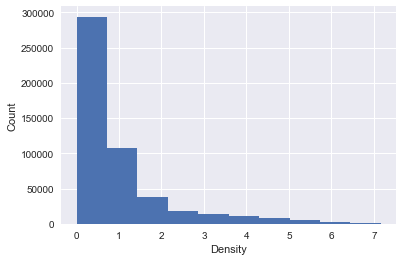

In [7]:
def histogram():
    plt.hist(test_densities)
    plt.ylabel('Count')
    plt.xlabel('Density')
    
histogram()

Plotting against position of the galaxy.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


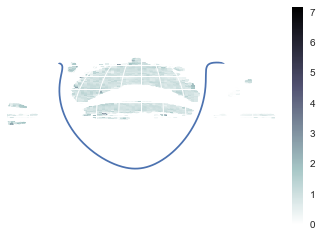

In [11]:
def plot_hex():
    mclearn.viz.plot_hex_map(test_meta['ra'],
                             test_meta['dec'],
                             C=test_densities,
                             gridsize=100,
                             vmin=np.min(test_densities),
                             vmax=np.max(test_densities))
    
plot_hex()

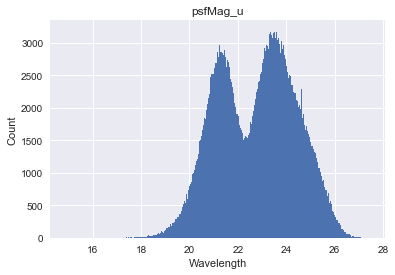

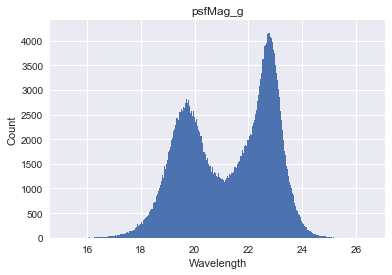

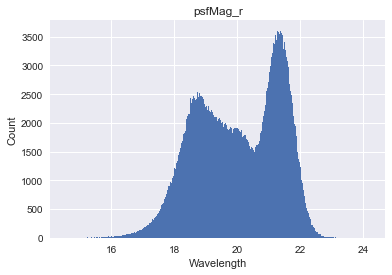

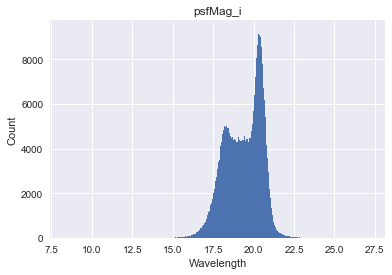

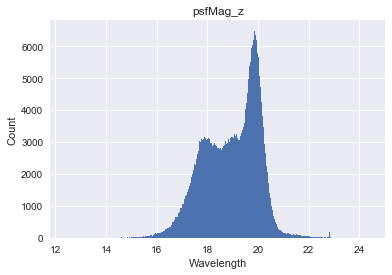

In [21]:
def plot_hist_by_band():
    bands_num = train_X.shape[1]
    for i in range(bands_num):
        fig, axes = plt.subplots()
        axes.hist(train_X[:,i], bins=1000)
        plt.ylabel('Count')
        plt.xlabel('Wavelength')
        plt.title(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z'][i])
    
plot_hist_by_band()

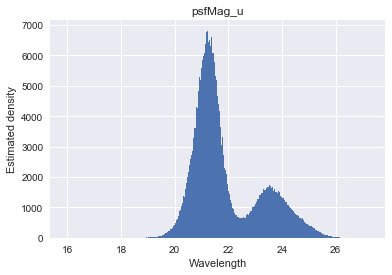

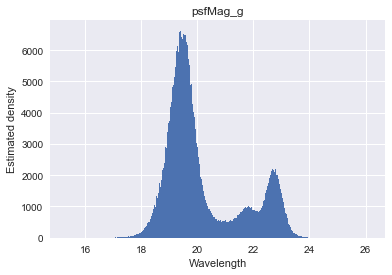

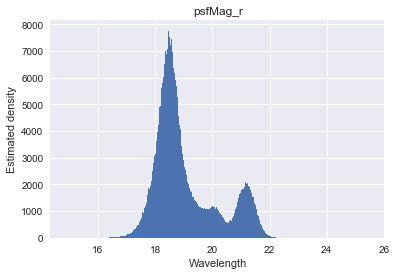

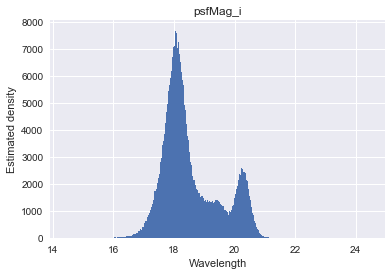

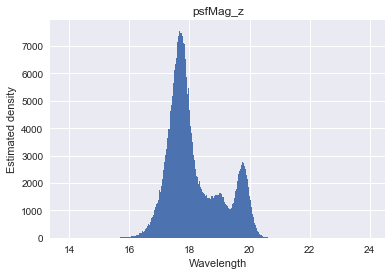

In [44]:
def plot_density_by_band():
    bands_num = train_X.shape[1]
    for i in range(bands_num):
        x = test_X[:,i]
        y = test_densities
        fig, axes = plt.subplots()
        axes.hist(x, weights=y, bins=500)
        plt.ylabel('Estimated density')
        plt.xlabel('Wavelength')
        plt.title(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z'][i])
    
plot_density_by_band()